In [1]:
import pandas as pd
from prophet import Prophet
import pickle
import numpy as np

# ------------------------------
# 1. Load dataset
# ------------------------------
df = pd.read_csv('final_df_binary.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total_task_time_minutes']
df = df.sort_values(['section_id','ds'])

# ------------------------------
# 2. Initialize storage for all predictions
# ------------------------------
sections = df['section_id'].unique()
predictions = pd.DataFrame()

# ------------------------------
# 3. Loop per section to fit Prophet
# ------------------------------
for sec in sections:
    sec_df = df[df['section_id']==sec].copy()
    
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.add_regressor('is_holiday')
    model.add_regressor('is_weekend')
    
    # Fit model
    model.fit(sec_df[['ds','y','is_holiday','is_weekend']])
    
    # Use all rows (including future) for prediction
    future_df = sec_df[['ds','is_holiday','is_weekend']].copy()
    forecast = model.predict(future_df)
    
    # Add section_id and select relevant columns
    forecast['section_id'] = sec
    forecast_sec = forecast[['ds','section_id','yhat','yhat_lower','yhat_upper']]
    
    predictions = pd.concat([predictions, forecast_sec], axis=0)

# ------------------------------
# 4. Post-processing
# ------------------------------
# Merge predictions with actuals
comparison = pd.merge(df, predictions, on=['ds','section_id'])

# Cap negative predictions at 0
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x,0))

# Recalculate errors
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 5. Save as pickle
# ------------------------------
with open('predictions_full.pkl', 'wb') as f:
    pickle.dump(comparison, f)

print("Predictions + post-processing saved successfully!")


21:05:36 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing
21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:40 - cmdstanpy - INFO - Chain [1] done processing
21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:41 - cmdstanpy - INFO - Chain [1] done processing
21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:42 - cmdstanpy - INFO - Chain [1] done processing
21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing


Predictions + post-processing saved successfully!


{'SEC-001': {'MAE': np.float64(293.83675898995386), 'MAPE (%)': np.float64(inf), 'RMSE': np.float64(430.9114390336711)}, 'SEC-002': {'MAE': np.float64(382.833507878453), 'MAPE (%)': np.float64(inf), 'RMSE': np.float64(514.525341826512)}, 'SEC-003': {'MAE': np.float64(281.3497224244095), 'MAPE (%)': np.float64(inf), 'RMSE': np.float64(389.1050359460385)}, 'SEC-004': {'MAE': np.float64(304.87995562489476), 'MAPE (%)': np.float64(inf), 'RMSE': np.float64(440.9187208386568)}, 'SEC-005': {'MAE': np.float64(802.5299505201953), 'MAPE (%)': np.float64(inf), 'RMSE': np.float64(1131.5673684871304)}, 'SEC-006': {'MAE': np.float64(604.207857574223), 'MAPE (%)': np.float64(inf), 'RMSE': np.float64(823.0886657693378)}}


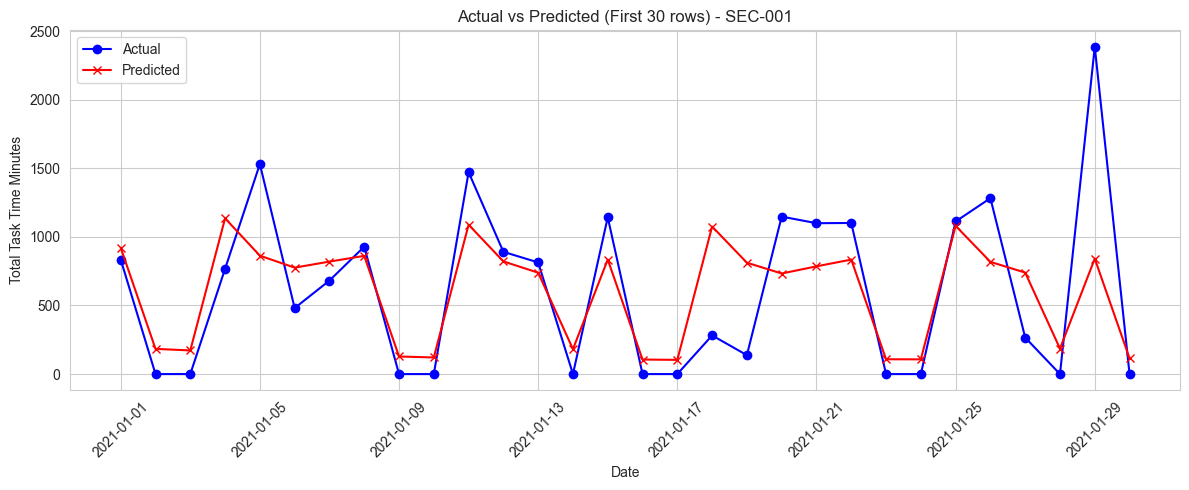

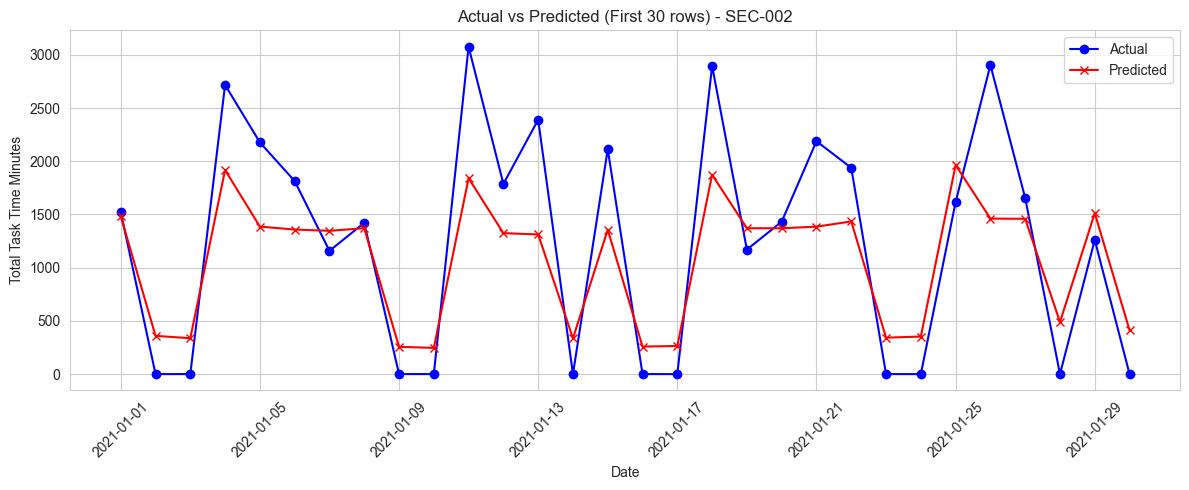

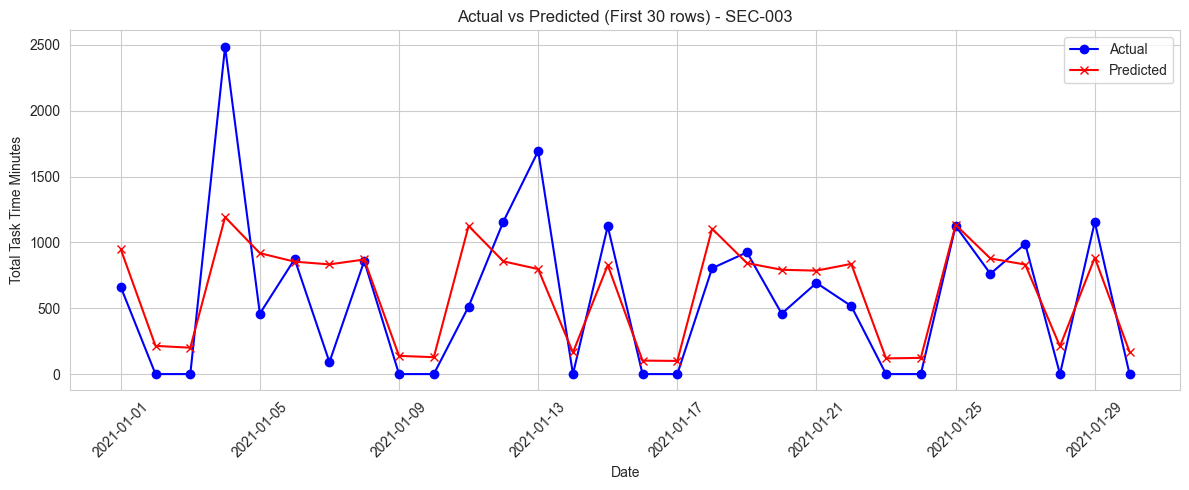

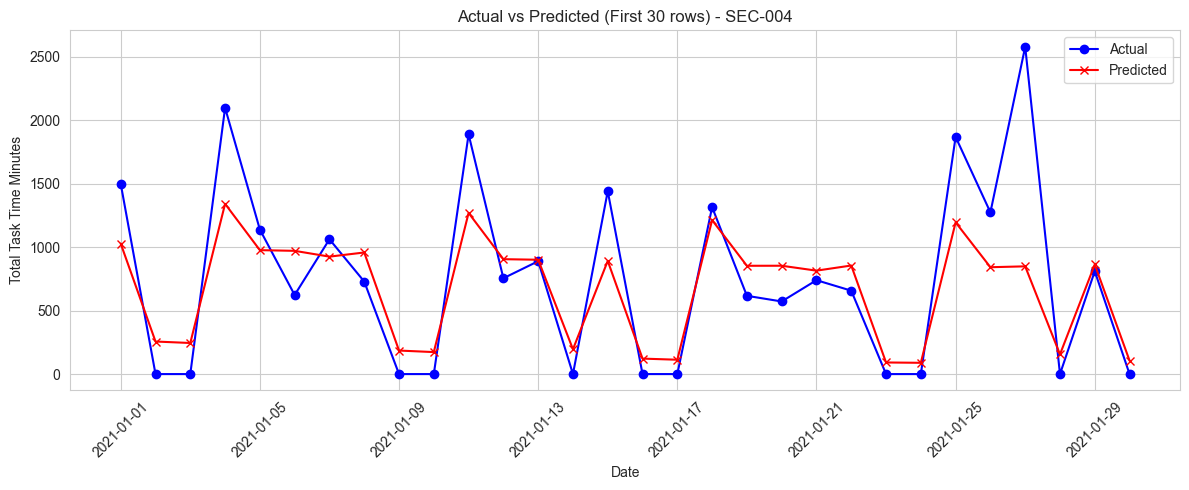

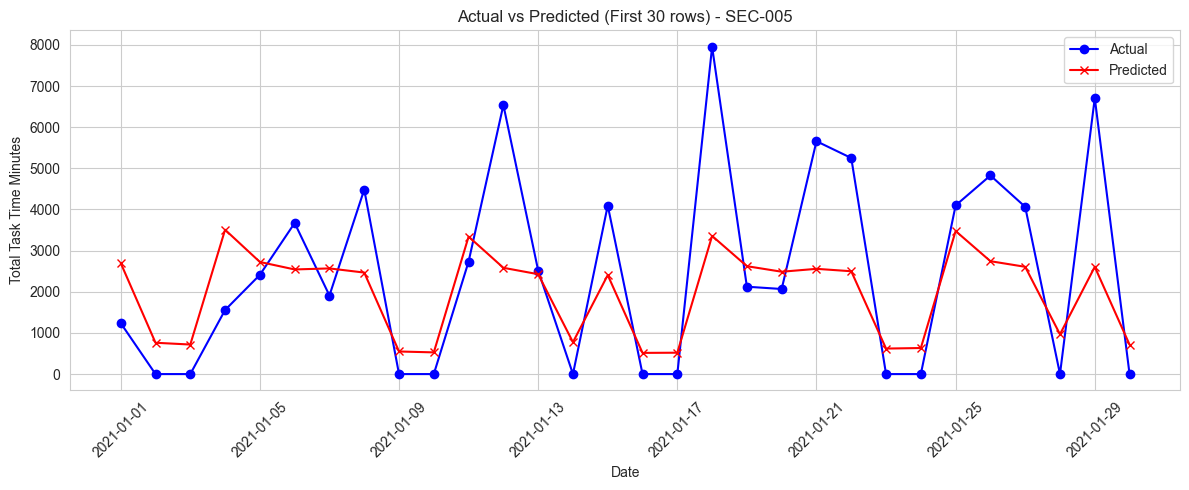

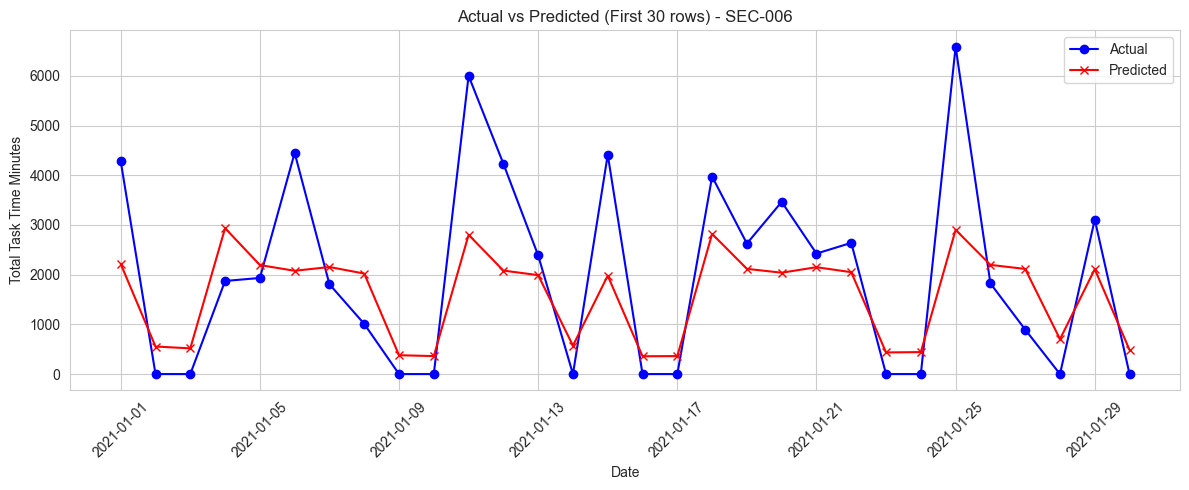

In [2]:
import pickle
import pandas as pd
import numpy as np

# ------------------------------
# Load pickle
# ------------------------------
with open('predictions_full.pkl', 'rb') as f:
    comparison = pickle.load(f)

# ------------------------------
# Example: Section-wise error metrics
# ------------------------------
sections = comparison['section_id'].unique()
section_errors = {}

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {'MAE': mae, 'MAPE (%)': mape, 'RMSE': rmse}

print(section_errors)

# ------------------------------
# Example: Plot first 30 rows per section
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].head(30)
    
    plt.figure(figsize=(12,5))
    plt.plot(sec_df['ds'], sec_df['y'], marker='o', label='Actual', color='blue')
    plt.plot(sec_df['ds'], sec_df['yhat'], marker='x', label='Predicted', color='red')
    plt.title(f"Actual vs Predicted (First 30 rows) - {sec}")
    plt.xlabel("Date")
    plt.ylabel("Total Task Time Minutes")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
